In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable


import tensorflow as tf

sys.path.append('..')
import helper
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency
np.random.seed(247)
tf.set_random_seed(247)

In [2]:

data_path = '../../data/RNAcompete_2013/rnacompete2013.h5'
experiments = helper.get_experiments_hdf5(data_path)

rbp_index = 69
ss_type = 'seq'
normalize_method = 'log_norm'

# load rbp dataset
train, valid, test = helper.load_dataset_hdf5(data_path, dataset_name=None, ss_type=ss_type, rbp_index=rbp_index)

# process rbp dataset
train, valid, test = helper.process_data(train, valid, test, method=normalize_method)
 

In [3]:
# set output file paths
model = 'affinity_residual_net'
genome_model = helper.import_model(model)
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape
model_layers, optimization = genome_model.model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)
nnmodel.inspect_layers()

# compile neural trainer
results_path = helper.make_directory('../../test', 'RNAcompete_2013')
save_path = helper.make_directory(results_path, normalize_method+'_'+ss_type)
file_path = os.path.join(save_path, str(rbp_index)+'_'+model+'_'+ss_type)
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=file_path)

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 41, 1, 4)
layer2: conv1d_0
(?, 30, 1, 96)
layer3: conv1d_0_batch
(?, 30, 1, 96)
layer4: conv1d_0_active
(?, 30, 1, 96)
layer5: conv1d_0_dropout
(?, 30, 1, 96)
layer6: conv1d_residual_0_1resid
(?, 30, 1, 96)
layer7: conv1d_residual_0_1resid_norm
(?, 30, 1, 96)
layer8: conv1d_residual_0_1resid_active
(?, 30, 1, 96)
layer9: conv1d_residual_0_dropout1
(?, 30, 1, 96)
layer10: conv1d_residual_0_2resid
(?, 30, 1, 96)
layer11: conv1d_residual_0_2resid_norm
(?, 30, 1, 96)
layer12: conv1d_residual_0_resid_sum
(?, 30, 1, 96)
layer13: conv1d_residual_0_resid
(?, 30, 1, 96)
layer14: conv1d_residual_0_meanpool
(?, 3, 1, 96)
layer15: conv1d_residual_0_dropout
(?, 3, 1, 96)
layer16: conv1d_1
(?, 1, 1, 192)
layer17: conv1d_1_batch
(?, 1, 1, 192)
layer18: conv1d_1_active
(?, 1, 1, 192)
layer19: conv1d_1_dropout


In [4]:
# initialize session
sess = utils.initialize_session()

In [5]:
# fit data
data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, batch_size=100, num_epochs=100, 
                      patience=20, verbose=2, shuffle=True, save_all=False)

Epoch 1 out of 100 
[==============================] 100.0% -- time=13s -- loss=1.02327 
  valid loss:		0.78319
  valid Pearson's R:	0.64303+/-0.00000
  valid rsquare:	0.22906+/-0.00000
  valid slope:		1.28265+/-0.00000
  lower cross-validation found
  saving model to:  ../../test/RNAcompete_2013/log_norm_seq/69_affinity_residual_net_seq_best.ckpt
Epoch 2 out of 100 
[==============================] 100.0% -- time=12s -- loss=0.65821 
  valid loss:		0.49710
  valid Pearson's R:	0.71386+/-0.00000
  valid rsquare:	0.50527+/-0.00000
  valid slope:		0.94967+/-0.00000
  lower cross-validation found
  saving model to:  ../../test/RNAcompete_2013/log_norm_seq/69_affinity_residual_net_seq_best.ckpt
Epoch 3 out of 100 
[==============================] 100.0% -- time=12s -- loss=0.57341 
  valid loss:		0.59387
  valid Pearson's R:	0.72013+/-0.00000
  valid rsquare:	0.41072+/-0.00000
  valid slope:		1.09730+/-0.00000
Epoch 4 out of 100 
[==============================] 100.0% -- time=12s -- loss=

Epoch 31 out of 100 
[==============================] 100.0% -- time=12s -- loss=0.32784 
  valid loss:		0.33809
  valid Pearson's R:	0.82123+/-0.00000
  valid rsquare:	0.66731+/-0.00000
  valid slope:		0.99974+/-0.00000
  lower cross-validation found
  saving model to:  ../../test/RNAcompete_2013/log_norm_seq/69_affinity_residual_net_seq_best.ckpt
Epoch 32 out of 100 
[==============================] 100.0% -- time=11s -- loss=0.33190 
  valid loss:		0.35525
  valid Pearson's R:	0.81905+/-0.00000
  valid rsquare:	0.65277+/-0.00000
  valid slope:		1.06584+/-0.00000
Epoch 33 out of 100 
[==============================] 100.0% -- time=12s -- loss=0.32727 
  valid loss:		0.36597
  valid Pearson's R:	0.81603+/-0.00000
  valid rsquare:	0.64056+/-0.00000
  valid slope:		1.03630+/-0.00000
Epoch 34 out of 100 
[==============================] 100.0% -- time=12s -- loss=0.32399 
  valid loss:		0.36299
  valid Pearson's R:	0.81696+/-0.00000
  valid rsquare:	0.65448+/-0.00000
  valid slope:		1.15

In [5]:
# load best model
nntrainer.set_best_parameters(sess)

# test modela
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, batch_size=128, name='test', verbose=1)

loading model from:  ../../test/RNAcompete_2013/log_norm_seq/69_affinity_residual_net_seq_best.ckpt
INFO:tensorflow:Restoring parameters from ../../test/RNAcompete_2013/log_norm_seq/69_affinity_residual_net_seq_best.ckpt
  test  loss:		0.36532
  test  Pearson's R:	0.80700+/-0.00000
  test  rsquare:	0.64268+/-0.00000
  test  slope:		1.05705+/-0.00000


/usr/lib/python2.7/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


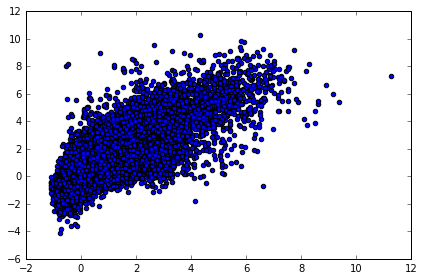

In [6]:
predictions = nntrainer.get_activations(sess, test, layer='output')
plt.scatter(predictions, test['targets'])
#outfile = os.path.join(save_path, 'test_scatter.pdf')
#fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 
#plt.close()

INFO:tensorflow:Restoring parameters from ../../test/RNAcompete_2013/log_norm_seq/69_affinity_residual_net_seq_best.ckpt


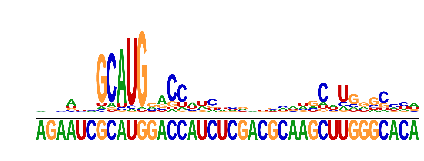

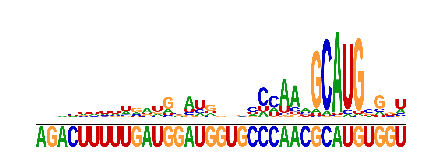

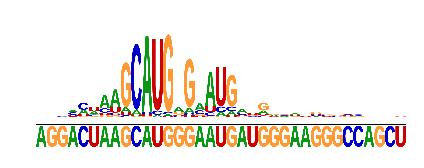

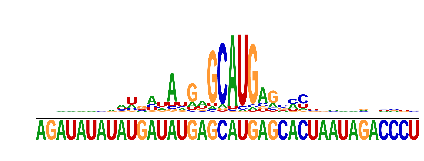

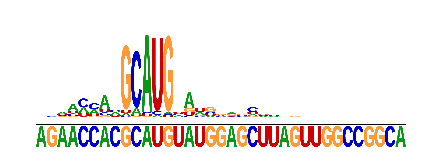

In [8]:
start = 100
num_plots = 5
max_indices = np.argsort(predictions[:,0])[::-1]  
plot_range = range(0,num_plots)
plot_index = max_indices[start:start+num_plots]
X = test['inputs'][plot_index]

# parameters for saliency analysis
params = {'genome_model': genome_model.model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'model_path': file_path+'_best.ckpt',
          'optimization': optimization
         }

# guided backprop saliency
guided_saliency = saliency.guided_backprop(X, layer='output', class_index=0, params=params)
    
for i in range(num_plots):
  
    # plot saliency comparison
    fig = plt.figure()
    plt = visualize.plot_seq_pos_saliency(np.squeeze(X)[i].T, np.squeeze(guided_saliency[i]).T, nt_width=100, norm_factor=3, alphabet='rna')
    
    #output_name = '{:.2f}'.format(predictions[i,0]) + '_' + '{:.2f}'.format(data['targets'][i,0])
    #outfile = os.path.join(save_path, output_name+'.pdf')
    #fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 
    #plt.close()

In [9]:
plot_index = [22536, 80541, 99819, 81328]
X = test['inputs'][plot_index]

INFO:tensorflow:Restoring parameters from ../../test/RNAcompete_2013/log_norm_seq/69_affinity_residual_net_seq_best.ckpt
INFO:tensorflow:Restoring parameters from ../../test/RNAcompete_2013/log_norm_seq/69_affinity_residual_net_seq_best.ckpt
INFO:tensorflow:Restoring parameters from ../../test/RNAcompete_2013/log_norm_seq/69_affinity_residual_net_seq_best.ckpt
INFO:tensorflow:Restoring parameters from ../../test/RNAcompete_2013/log_norm_seq/69_affinity_residual_net_seq_best.ckpt
INFO:tensorflow:Restoring parameters from ../../test/RNAcompete_2013/log_norm_seq/69_affinity_residual_net_seq_best.ckpt


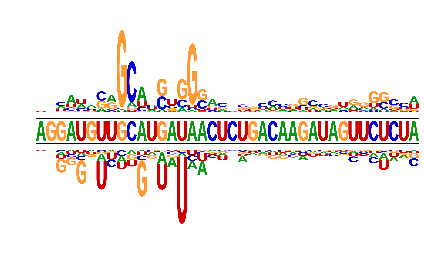

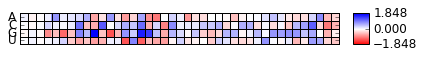

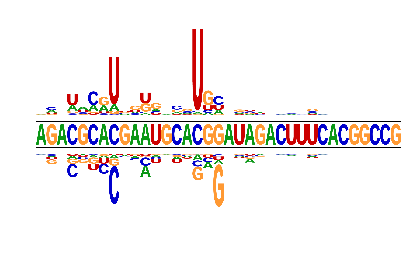

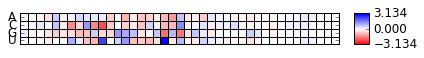

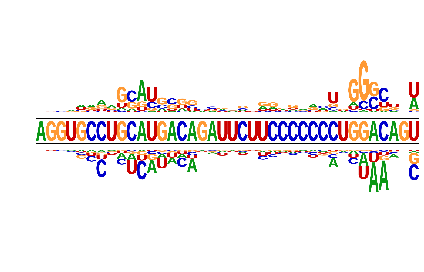

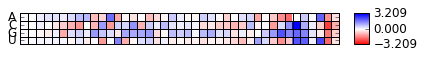

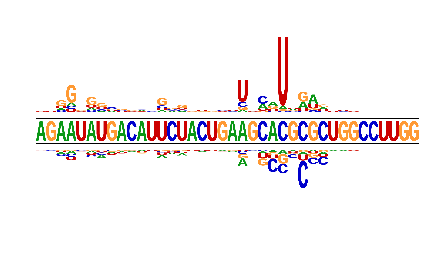

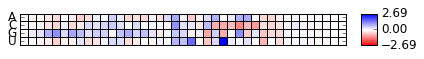

In [10]:
# parameters for saliency analysis
params = {'genome_model': genome_model.model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'model_path': file_path+'_best.ckpt',
          'optimization': optimization
         }

# guided backprop saliency
guided_saliency = saliency.backprop(X, layer='output', class_index=0, params=params)
    
for index in range(len(plot_index)):
    
    guided_saliency = saliency.backprop(np.expand_dims(X[index], axis=0), layer='output', class_index=0, params=params)
    
    # plot saliency comparison
    fig = plt.figure()
    #plt = visualize.plot_seq_struct_saliency(np.squeeze(X).T, np.squeeze(guided_saliency).T, nt_width=100, norm_factor=3)
    plt = visualize.plot_seq_neg_saliency(np.squeeze(X[index]).T[:4,:], np.squeeze(guided_saliency).T[:4,:], nt_width=100, norm_factor=3, alphabet='rna')
    outfile = os.path.join(save_path, 'backprop_saliency_'+str(index) + '.pdf')
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 


    fig = plt.figure()
    W = np.squeeze(guided_saliency).T[:4,:]
    MAX = np.max(np.abs(W))
    norm = matplotlib.colors.Normalize(vmin=-MAX, vmax=MAX)
    im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
    ax = plt.gca()
    ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
    ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
    ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
    plt.xticks([]);
    plt.yticks([])
    if W.shape[0] == 4:
        plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
    else:
        plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
    #cbar = plt.colorbar();
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticks([-MAX, 0., MAX])
    outfile = os.path.join(save_path, 'backprop_map_'+str(index) + '.pdf')
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 
    

INFO:tensorflow:Restoring parameters from ../../test/RNAcompete_2013/log_norm_seq/69_affinity_residual_net_seq_best.ckpt
INFO:tensorflow:Restoring parameters from ../../test/RNAcompete_2013/log_norm_seq/69_affinity_residual_net_seq_best.ckpt
INFO:tensorflow:Restoring parameters from ../../test/RNAcompete_2013/log_norm_seq/69_affinity_residual_net_seq_best.ckpt
INFO:tensorflow:Restoring parameters from ../../test/RNAcompete_2013/log_norm_seq/69_affinity_residual_net_seq_best.ckpt


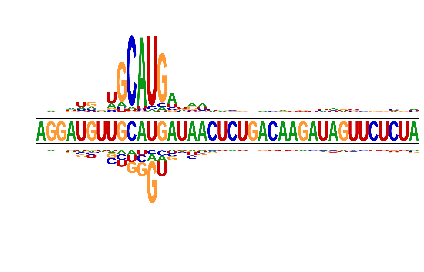

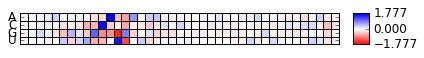

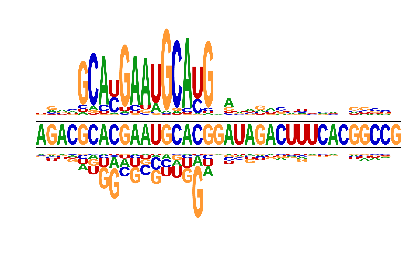

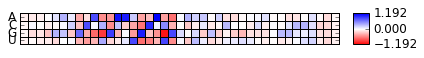

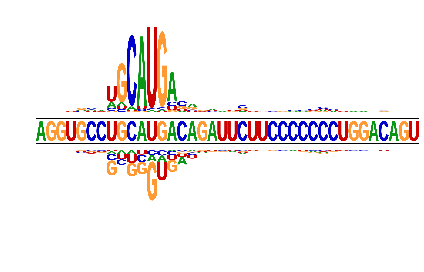

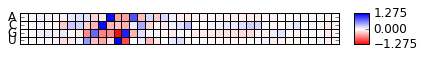

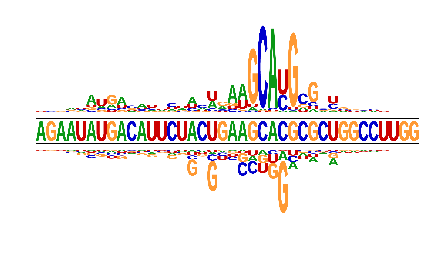

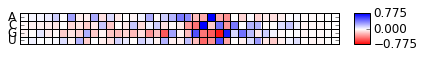

In [11]:
# parameters for saliency analysis
params = {'genome_model': genome_model.model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'model_path': file_path+'_best.ckpt',
          'optimization': optimization
         }


for index in range(len(plot_index)):
    
    guided_saliency = saliency.guided_backprop(np.expand_dims(X[index], axis=0), layer='output', class_index=0, params=params)
    
    # plot saliency comparison
    fig = plt.figure()
    #plt = visualize.plot_seq_struct_saliency(np.squeeze(X).T, np.squeeze(guided_saliency).T, nt_width=100, norm_factor=3)
    plt = visualize.plot_seq_neg_saliency(np.squeeze(X[index]).T[:4,:], np.squeeze(guided_saliency).T[:4,:], nt_width=100, norm_factor=3, alphabet='rna')
    outfile = os.path.join(save_path, 'guidedbackprop_saliency_'+str(index) + '.pdf')
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 

    fig = plt.figure()
    W = np.squeeze(guided_saliency).T[:4,:]
    MAX = np.max(np.abs(W))
    norm = matplotlib.colors.Normalize(vmin=-MAX, vmax=MAX)
    im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
    ax = plt.gca()
    ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
    ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
    ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
    plt.xticks([]);
    plt.yticks([])
    if W.shape[0] == 4:
        plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
    else:
        plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
    #cbar = plt.colorbar();
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticks([-MAX, 0., MAX])
    outfile = os.path.join(save_path, 'guidedbackprop_map_'+str(index) + '.pdf')
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 
    

# mutagenesis 

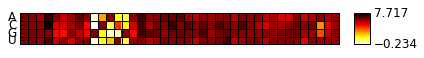

In [84]:

index = 0

mutations = []
for j in range(X.shape[1]):
    for i in range(4):
        x = np.copy(np.expand_dims(X[index], axis=0))
        x[0,j,0,:4] = 0
        x[0,j,0,i] = 1
        mutations.append(x)
mutations = np.vstack(mutations)
activations = nntrainer.get_activations(sess, {'inputs': mutations})
baseline = nntrainer.get_activations(sess, {'inputs': x})

mutagenesis = np.zeros((X.shape[1], 4))
k = 0
for j in range(X.shape[1]):
    for i in range(4):
        mutagenesis[j,i] = activations[k,0]
        k += 1

mutagenesis_norm = mutagenesis/baseline[0] - 1
MAX = np.max(np.abs(mutagenesis_norm))
mutagenesis_rescale = mutagenesis_norm/MAX

fig = plt.figure()
W = mutagenesis.T
MAX = np.max(W)
MIN = np.min(W)
norm = matplotlib.colors.Normalize(vmin=MIN, vmax=MAX)
im = plt.imshow(W, interpolation='none', cmap='hot_r', norm=norm)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([MIN, MAX])

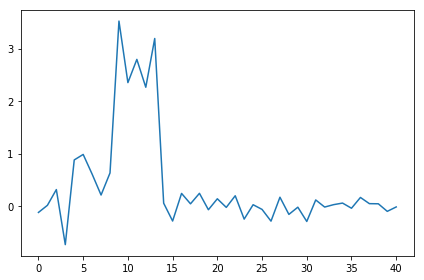

In [319]:
direction = -np.mean(mutagenesis-baseline, axis=1)
plt.plot(direction)

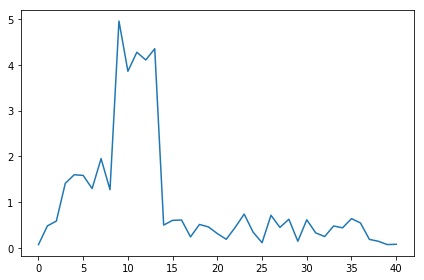

In [320]:
sensitivity = np.max(mutagenesis, axis=1)-np.min(mutagenesis, axis=1)
plt.plot(sensitivity)

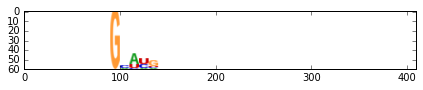

In [85]:
#mutagenesis -= np.min(mutagenesis)
norm = np.sum(mutagenesis, axis=1, keepdims=True)
W = mutagenesis/norm
logo = visualize.seq_logo(W.T, alphabet='rna')
plt.imshow(logo)

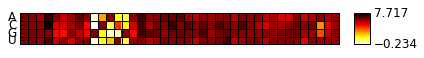

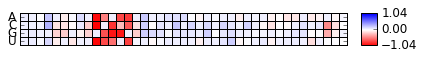

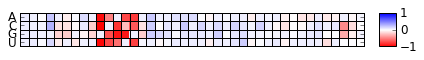

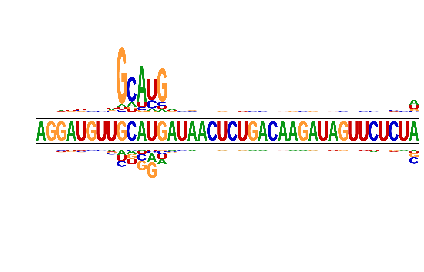

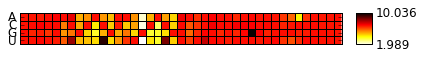

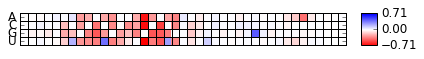

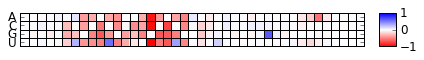

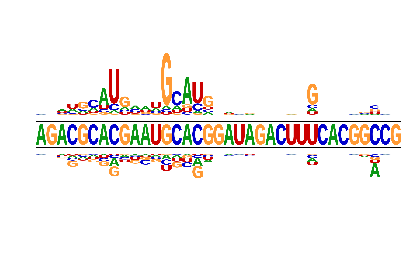

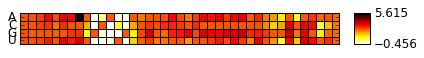

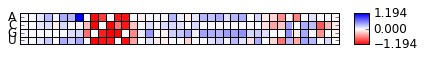

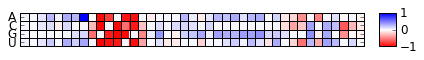

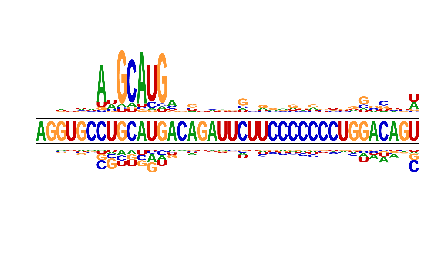

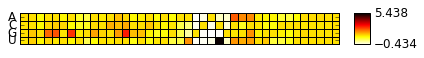

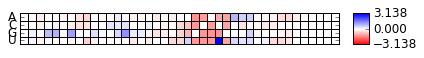

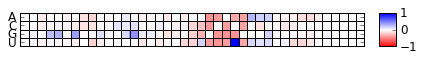

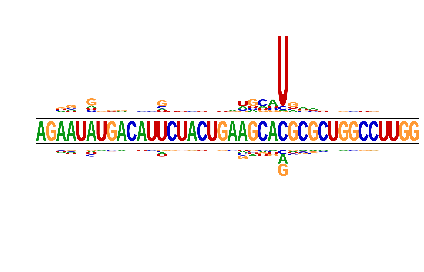

In [86]:

for index in range(4):

    mutations = []
    for j in range(X.shape[1]):
        for i in range(4):
            x = np.copy(np.expand_dims(X[index], axis=0))
            x[0,j,0,:4] = 0
            x[0,j,0,i] = 1
            mutations.append(x)
    mutations = np.vstack(mutations)
    activations = nntrainer.get_activations(sess, {'inputs': mutations})
    baseline = nntrainer.get_activations(sess, {'inputs': x})

    mutagenesis = np.zeros((X.shape[1], 4))
    k = 0
    for j in range(X.shape[1]):
        for i in range(4):
            mutagenesis[j,i] = activations[k,0]
            k += 1

    mutagenesis_norm = mutagenesis/baseline[0] - 1
    MAX = np.max(np.abs(mutagenesis_norm))
    mutagenesis_rescale = mutagenesis_norm/MAX


    fig = plt.figure()
    W = mutagenesis.T
    MAX = np.max(W)
    MIN = np.min(W)
    norm = matplotlib.colors.Normalize(vmin=MIN, vmax=MAX)
    im = plt.imshow(W, interpolation='none', cmap='hot_r', norm=norm)
    ax = plt.gca()
    ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
    ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
    ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
    plt.xticks([]);
    plt.yticks([])
    if W.shape[0] == 4:
        plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
    else:
        plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
    #cbar = plt.colorbar();
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticks([MIN, MAX])
    outfile = os.path.join(save_path, 'mutagenesis_'+str(index) + '.pdf')
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 


    fig = plt.figure()
    W = mutagenesis_norm.T
    MAX = np.max(np.abs(W))
    norm = matplotlib.colors.Normalize(vmin=-MAX, vmax=MAX)
    im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
    ax = plt.gca()
    ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
    ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
    ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
    plt.xticks([]);
    plt.yticks([])
    if W.shape[0] == 4:
        plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
    else:
        plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
    #cbar = plt.colorbar();
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticks([-MAX, 0., MAX])
    outfile = os.path.join(save_path, 'mutagenesis_rescale_'+str(index) + '.pdf')
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 


    fig = plt.figure()
    W = mutagenesis_rescale.T
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
    ax = plt.gca()
    ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
    ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
    ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
    plt.xticks([]);
    plt.yticks([])
    if W.shape[0] == 4:
        plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
    else:
        plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
    #cbar = plt.colorbar();
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticks([-1.0, 0., 1.0])
    outfile = os.path.join(save_path, 'mutagenesis_norm_'+str(index) + '.pdf')
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 

    # plot saliency comparison
    fig = plt.figure()
    plt = visualize.plot_seq_neg_saliency(np.squeeze(X[index]).T[:4,:], mutagenesis_rescale.T, nt_width=100, norm_factor=1, alphabet='rna')
    outfile = os.path.join(save_path, 'mutagenesis_saliency_'+str(index) + '.pdf')
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 

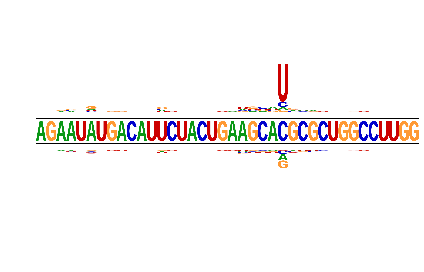

In [88]:
# plot saliency comparison
fig = plt.figure()
plt = visualize.plot_seq_neg_saliency(np.squeeze(X[index]).T[:4,:], mutagenesis_rescale.T, nt_width=100, norm_factor=2, alphabet='rna')


# mutagenesis perturbation (w/ epsilon)

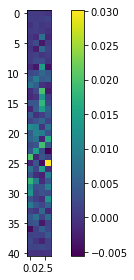

In [83]:

mutagenesis = np.zeros((X.shape[1], 4))
k = 0
for j in range(X.shape[1]):
    for i in range(4):
        mutagenesis[j,i] = (pos_activations[k,0] - neg_activations[k,0])/2
        k += 1
plt.figure()
plt.imshow(mutagenesis/baseline)
plt.colorbar()


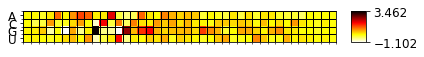

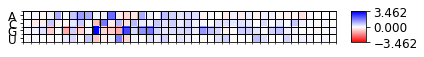

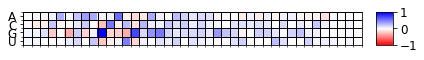

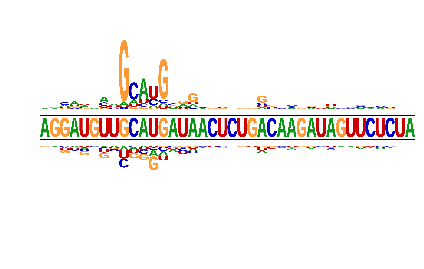

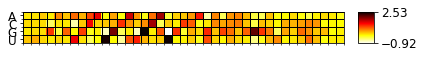

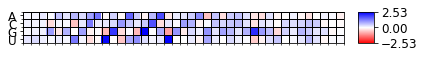

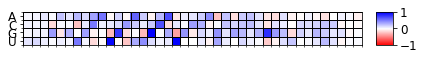

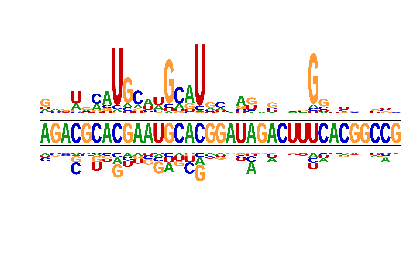

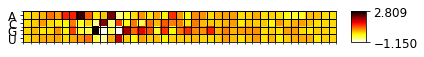

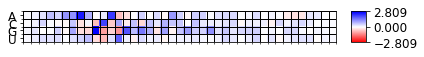

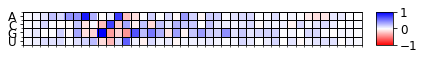

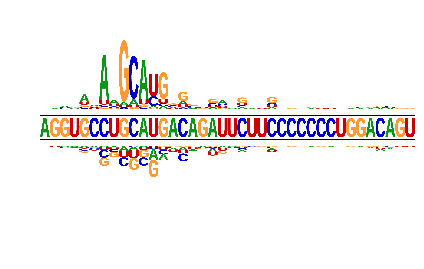

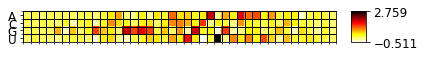

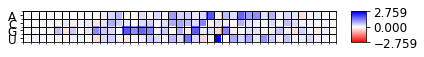

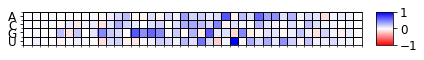

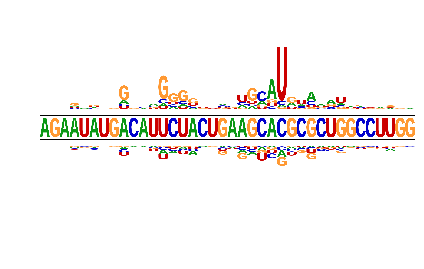

In [89]:
epsilon = 0.01

for index in range(4):
    pos_mutations = []
    for j in range(X.shape[1]):
        for i in range(4):
            x = np.copy(np.expand_dims(X[index], axis=0))
            x[0,j,0,i] += epsilon
            pos_mutations.append(x)
    pos_mutations = np.vstack(pos_mutations)
    pos_activations = nntrainer.get_activations(sess, {'inputs': pos_mutations})
    
    
    neg_mutations = []
    for j in range(X.shape[1]):
        for i in range(4):
            x = np.copy(np.expand_dims(X[index], axis=0))
            x[0,j,0,i] -= epsilon
            neg_mutations.append(x)
    neg_mutations = np.vstack(neg_mutations)
    neg_activations = nntrainer.get_activations(sess, {'inputs': neg_mutations})
    
    activations = (pos_activations - neg_activations)/(2*epsilon)

    baseline = nntrainer.get_activations(sess, {'inputs': x})

    mutagenesis = np.zeros((X.shape[1], 4))
    k = 0
    for j in range(X.shape[1]):
        for i in range(4):
            mutagenesis[j,i] = activations[k,0]
            k += 1

    mutagenesis_norm = mutagenesis
    MAX = np.max(np.abs(mutagenesis_norm))
    mutagenesis_rescale = mutagenesis_norm/MAX


    fig = plt.figure()
    W = mutagenesis.T
    MAX = np.max(W)
    MIN = np.min(W)
    norm = matplotlib.colors.Normalize(vmin=MIN, vmax=MAX)
    im = plt.imshow(W, interpolation='none', cmap='hot_r', norm=norm)
    ax = plt.gca()
    ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
    ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
    ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
    plt.xticks([]);
    plt.yticks([])
    if W.shape[0] == 4:
        plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
    else:
        plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
    #cbar = plt.colorbar();
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticks([MIN, MAX])
    outfile = os.path.join(save_path, 'epsilon_'+str(index) + '.pdf')
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 


    fig = plt.figure()
    W = mutagenesis_norm.T
    MAX = np.max(np.abs(W))
    norm = matplotlib.colors.Normalize(vmin=-MAX, vmax=MAX)
    im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
    ax = plt.gca()
    ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
    ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
    ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
    plt.xticks([]);
    plt.yticks([])
    if W.shape[0] == 4:
        plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
    else:
        plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
    #cbar = plt.colorbar();
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticks([-MAX, 0., MAX])
    outfile = os.path.join(save_path, 'epsilon_rescale_'+str(index) + '.pdf')
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 


    fig = plt.figure()
    W = mutagenesis_rescale.T
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
    ax = plt.gca()
    ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
    ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
    ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
    plt.xticks([]);
    plt.yticks([])
    if W.shape[0] == 4:
        plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
    else:
        plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
    #cbar = plt.colorbar();
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticks([-1.0, 0., 1.0])
    outfile = os.path.join(save_path, 'epsilon_norm_'+str(index) + '.pdf')
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 

    # plot saliency comparison
    fig = plt.figure()
    plt = visualize.plot_seq_neg_saliency(np.squeeze(X[index]).T[:4,:], mutagenesis_rescale.T, nt_width=100, norm_factor=3, alphabet='rna')
    outfile = os.path.join(save_path, 'epsilon_saliency_'+str(index) + '.pdf')
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 

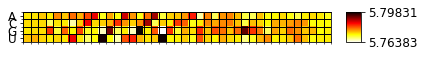

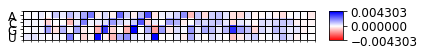

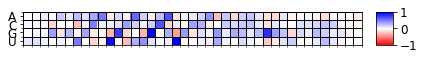

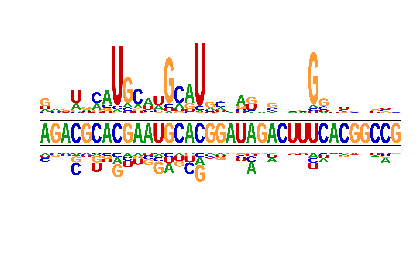

In [63]:
index = 1
mutations = []
for j in range(X.shape[1]):
    for i in range(4):
        x = np.copy(np.expand_dims(X[index], axis=0))
        x[0,j,0,i] += epsilon
        mutations.append(x)
mutations = np.vstack(mutations)
activations = nntrainer.get_activations(sess, {'inputs': mutations})
baseline = nntrainer.get_activations(sess, {'inputs': x})

mutagenesis = np.zeros((X.shape[1], 4))
k = 0
for j in range(X.shape[1]):
    for i in range(4):
        mutagenesis[j,i] = activations[k,0]
        k += 1

mutagenesis_norm = mutagenesis/baseline[0] - 1
MAX = np.max(np.abs(mutagenesis_norm))
mutagenesis_rescale = mutagenesis_norm/MAX


plt.figure()
W = mutagenesis.T
MAX = np.max(W)
MIN = np.min(W)
norm = matplotlib.colors.Normalize(vmin=MIN, vmax=MAX)
im = plt.imshow(W, interpolation='none', cmap='hot_r', norm=norm)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([MIN, MAX])


plt.figure()
W = mutagenesis_norm.T
MAX = np.max(np.abs(W))
norm = matplotlib.colors.Normalize(vmin=-MAX, vmax=MAX)
im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([-MAX, 0., MAX])


plt.figure()
W = mutagenesis_rescale.T
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([-1.0, 0., 1.0])

# plot saliency comparison
fig = plt.figure()
plt = visualize.plot_seq_neg_saliency(np.squeeze(X[index]).T[:4,:], mutagenesis_rescale.T, nt_width=100, norm_factor=3, alphabet='rna')


In [ ]:
epsilon = .01
mutations = []
for j in range(X.shape[1]):
    for i in range(4):
        x = np.copy(X)
        x[0,j,0,:4] = 0
        x[0,j,0,i] = 1+epsilon
        mutations.append(x)
mutations = np.vstack(mutations)
        
    
activations = nntrainer.get_activations(sess, {'inputs': mutations})
baseline = nntrainer.get_activations(sess, {'inputs': X})

In [ ]:
mutagenesis = np.zeros((X.shape[1], 4))
k = 0
for j in range(X.shape[1]):
    for i in range(4):
        mutagenesis[j,i] = activations[k,0]
        k += 1
        
mutagenesis_norm = mutagenesis/baseline[0] - 1
mutagenesis_rescale = mutagenesis_norm/np.max(np.abs(mutagenesis_norm))



plt.figure()
W = mutagenesis.T
MAX = np.max(W)
MIN = np.min(W)
norm = matplotlib.colors.Normalize(vmin=MIN, vmax=MAX)
im = plt.imshow(W, interpolation='none', cmap='hot_r', norm=norm)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([MIN, MAX])


plt.figure()
W = mutagenesis_norm.T
MAX = np.max(np.abs(W))
norm = matplotlib.colors.Normalize(vmin=-MAX, vmax=MAX)
im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([-MAX, 0., MAX])


plt.figure()
W = mutagenesis_rescale.T
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([-1.0, 0., 1.0])


In [ ]:
# plot saliency comparison
fig = plt.figure()
plt = visualize.plot_seq_neg_saliency(np.squeeze(X).T[:4,:], mutagenesis_rescale.T, nt_width=100, norm_factor=3, alphabet='rna')